# Classifying White Blood Cells

### Introduction

An important problem in blood diagnostics is classifying different types of blood cells. In this notebook, we will attempt to train a classifier to predict the type of a blood cell given a dyed picture of it.

### Data

We have 351 pictures of dyed white blood cells along with labels of what type of blood cell they are. Below is an example of each of the types of blood cells in our dataset.

##### Basophil
![Basophil](Basophil.jpg)

#### Eosinophil
![Eosinophil](Eosinophil.jpg)

#### Lymphocyte
![Lymphocyte](Lymphocyte.jpg)

#### Monocyte
![Monocyte](Monocyte.jpg)

#### Neutrophil
![Neutrophil](Neutrophil.jpg)

### Methodology

We use a simple LeNet architecture trained on 280 training samples with image augmentation. Our augmentation techniques include rotations, shifts, and zooms.

We validate our results against 70 samples.

### Results

We obtain an accuracy of 93% on this validation set with the following confusion matrix:

![Confusion Matrix](confusion_matrix.png)


### Conclusion

I think these results show that it is possible to train a strong classifier for WBCs that can approach really strong accuracies with more and more data.

### Next Steps

It's hard to try and improve the results with so little validation data. Fixing one prediction here or there would lead to a big change in accuracy etc. The next steps should be to augment our training and test sets with further image augmentation techniques or just more real data.

Here are some potential techniques to improve accuracy:

* Use color thresholding to find the center of each WBC and crop the images to be centered around those areas.
* Use VGG net etc. and retrain the last few layers.
* Balance out the dataset through image augmentation.


# Code

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
import csv
import cv2
import scipy


KeyboardInterrupt: 

In [10]:
num_classes = 5
epochs = 20
# BASE_PATH = '/home/ec2-user/cell_classifier/'
BASE_PATH = '../'
batch_size = 32

In [4]:
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
    model.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

    return model

In [6]:
def get_filename_for_index(index):
    PREFIX = 'images/BloodImage_'
    num_zeros = 5 - len(index)
    path = '0' * num_zeros + index
    return PREFIX + path + '.jpg'

In [17]:
reader = csv.reader(open(BASE_PATH + 'labels.csv'))
# skip the header
next(reader)

X = []
y = []

for row in reader:
    label = row[2]
    if len(label) > 0 and label.find(',') == -1:
        filename = get_filename_for_index(row[1])
        img_file = cv2.imread(BASE_PATH + filename)
        if img_file is not None:
            img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
            img_arr = np.asarray(img_file)
            img_arr = apply_color_mask(img_arr)
            X.append(img_arr)
            y.append(label)


X = np.asarray(X)
y = np.asarray(y)

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

y = np_utils.to_categorical(encoded_y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [20]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [21]:
train_generator = datagen.flow(
        X_train,
        y_train,
        batch_size=batch_size)

validation_generator = datagen.flow(
        X_test,
        y_test,
        batch_size=batch_size)

In [23]:
model = get_model()

# fits the model on batches with real-time data augmentation:
model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train),
    validation_data=validation_generator,
    validation_steps=len(X_test),
    epochs=epochs)
model.save_weights('mask_1.h5')  # always save your weights after training or during training

Epoch 1/20
133/280 [=============>................] - ETA: 192s - loss: 1.2470 - acc: 0.5345

KeyboardInterrupt: 

# Load Model

In [11]:
model = get_model()
model.load_weights('first_try.h5')

# Accuracy

In [12]:
print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))

Predicting on test data


In [13]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.929577464789


# Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix

y_pred_unencoded = np.argmax(y_pred, axis=1)
y_test_unencoded = np.argmax(y_test, axis=1)

print(confusion_matrix(y_test_unencoded, y_pred_unencoded))

[[11  0  0  2]
 [ 0  6  0  0]
 [ 0  0  3  1]
 [ 2  0  0 46]]


In [106]:
encoder.inverse_transform([0, 1, 2, 3, 4])

array(['BASOPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], 
      dtype='<U10')

# Eosinophils

In [107]:
eosinophils = np.where(y_pred[:,1] == 1)

In [108]:
eosinophils

(array([11, 15, 16, 23, 33, 39, 40, 47, 52, 56, 58, 63, 70]),)

IS CORRECT? False
[ 0.  1.  0.  0.  0.]
[ 0.  1.  0.  0.  0.]


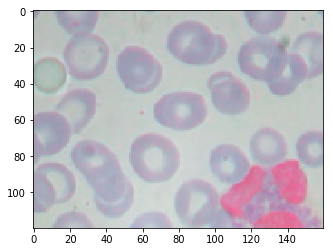

In [112]:
print("IS CORRECT?", np.array_equal(y_test[11],y_pred[11]))
print(y_test[11])
print(y_pred[11])
imshow(X_test[11])

IS CORRECT? True
[ 0.  1.  0.  0.  0.]
[ 0.  1.  0.  0.  0.]


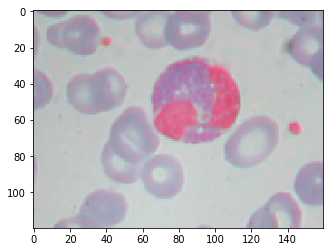

In [125]:
print("IS CORRECT?", np.array_equal(y_test[11],y_pred[11]))
print(y_test[15])
print(y_pred[15])
imshow(X_test[15])

In [1]:
print("IS CORRECT?", np.array_equal(y_test[11],y_pred[11]))
print(y_test[16])
print(y_pred[16])
imshow(X_test[16])

NameError: name 'np' is not defined

IS CORRECT? True
[ 0.  1.  0.  0.  0.]
[ 0.  1.  0.  0.  0.]


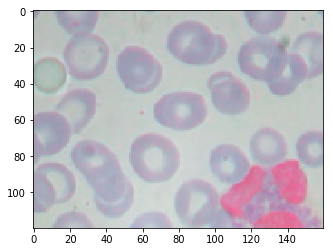

In [126]:
print("IS CORRECT?", np.array_equal(y_test[11],y_pred[11]))
print(y_test[11])
print(y_pred[11])
imshow(X_test[11])

# Lymphocytes

In [120]:
lymphocytes = np.where(y_pred[:,2] == 1)
print(lymphocytes)

(array([22, 32, 42, 45, 51, 60]),)


IS CORRECT? True
[ 0.  0.  1.  0.  0.]
[ 0.  0.  1.  0.  0.]


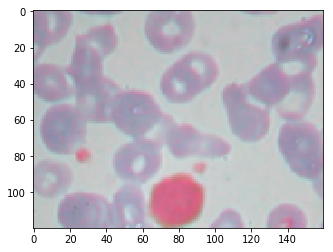

In [121]:
print("IS CORRECT?", np.array_equal(y_test[22],y_pred[22]))
print(y_test[22])
print(y_pred[22])
imshow(X_test[22])

IS CORRECT? True
[ 0.  0.  1.  0.  0.]
[ 0.  0.  1.  0.  0.]


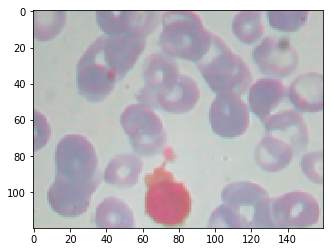

In [122]:
print("IS CORRECT?", np.array_equal(y_test[22],y_pred[22]))
print(y_test[32])
print(y_pred[32])
imshow(X_test[32])

IS CORRECT? True
[ 0.  0.  1.  0.  0.]
[ 0.  0.  1.  0.  0.]


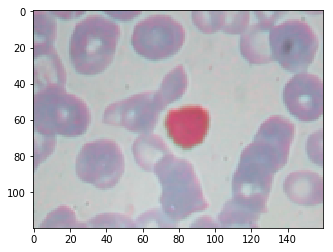

In [123]:
print("IS CORRECT?", np.array_equal(y_test[22],y_pred[22]))
print(y_test[60])
print(y_pred[60])
imshow(X_test[60])

# Monocytes

In [124]:
monocytes = np.where(y_pred[:,3] == 1)
print(monocytes)

(array([ 6, 28, 38]),)


IS CORRECT? True
[ 0.  0.  0.  1.  0.]
[ 0.  0.  0.  1.  0.]


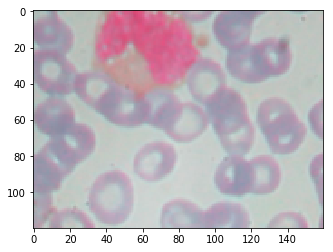

In [128]:
print("IS CORRECT?", np.array_equal(y_test[6],y_pred[6]))
print(y_test[6])
print(y_pred[6])
imshow(X_test[6])

IS CORRECT? True
[ 0.  0.  0.  1.  0.]
[ 0.  0.  0.  1.  0.]


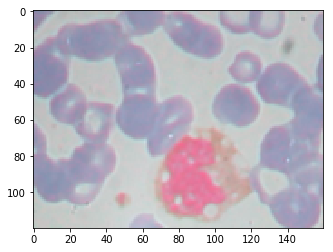

In [129]:
print("IS CORRECT?", np.array_equal(y_test[28],y_pred[28]))
print(y_test[28])
print(y_pred[28])
imshow(X_test[28])